In [ ]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 1 input

In [ ]:
# one input

def f(x):
    return x**2 + 3*x

In [3]:
f(2.0)

10.0

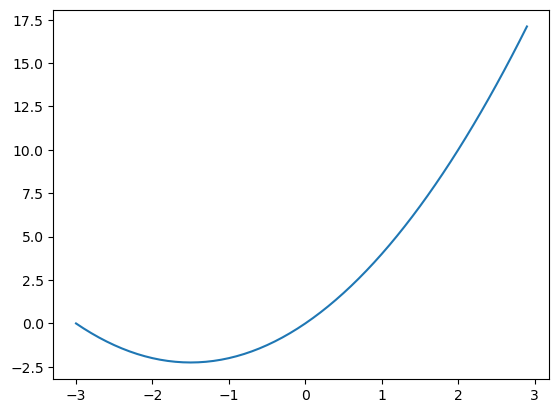

In [4]:
xs = np.arange(-3, 3, 0.1)
ys = f(xs)
plt.plot(xs, ys)

In [6]:
x = -2
h = 0.001
(f(x + h) - f(x))/h

-0.998999999999306

## Multiple inputs

### Tính tổng chi phí mua đồ ăn

Ý tưởng: Giả sử tổng chi phí T phụ thuộc vào:

- x: số phần ăn
- y: giá mỗi phần
- z: phí giao hàng cố định

Công thức: 
### 𝑇 = 𝑥.𝑦 + 𝑧

Ta muốn biết:

- Nếu tăng số phần ăn x một chút, tổng tiền thay đổi thế nào?
- Nếu tăng giá mỗi phần y một chút, tổng tiền thay đổi thế nào?
- Nếu tăng phí giao hàng z một chút, tổng tiền thay đổi thế nào?

In [ ]:
# inputs
x = 3.0      # số phần ăn
y = 50.0     # giá mỗi phần
z = 20.0     # phí giao hàng

T = x*y + z
print(T)

170.0


In [18]:
h = 0.00001

T1 = x*y + z
z += h       # tăng z lên một chút
T2 = x*y + z

print('T1', T1)
print('T2', T2)
print('slope', (T2 - T1)/h)

T1 170.00157000060003
T2 170.00158000060003
slope 1.0000000003174137


# Forward pass
xây dựng biểu thức toán học (+/-/*/:), thực hiện forward pass

In [95]:
class Node:

  def __init__(self, data, inputs=(), operation='', name=''):
    self.data = data
    self.gradient = 0.0
    self._backward_fn = lambda: None
    self._inputs = set(inputs)
    self._operation = operation
    self.name = name
  
  def __repr__(self):
    return f"Node(data={self.data})"

  def __mul__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data * other.data, (self, other), '*')

    def _backward_fn():
      self.gradient += other.data * out.gradient
      other.gradient += self.data * out.gradient
    out._backward_fn = _backward_fn

    return out
  
  def __rmul__(self, other): # other * self
    return self * other
  
  def __sub__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data - other.data, (self, other), '-')

    def _backward_fn():
      self.gradient += 1.0 * out.gradient
      other.gradient += -1.0 * out.gradient
    out._backward_fn = _backward_fn

    return out
  
  def __rsub__(self, other):  # other - self
    return Node(other) - self

  def __add__(self, other):
    other = other if isinstance(other, Node) else Node(other)
    out = Node(self.data + other.data, (self, other), '+')

    def _backward_fn():
      self.gradient += 1.0 * out.gradient
      other.gradient += 1.0 * out.gradient
    out._backward_fn = _backward_fn

    return out

  def tanh(self):
    val = self.data
    t = (math.exp(2*val) - 1)/(math.exp(2*val) + 1)
    out = Node(t, (self, ), 'tanh')
    
    def _backward_fn():
      self.gradient += (1 - t**2) * out.gradient
    out._backward_fn = _backward_fn

    return out
  
  def exp(self):
    val = self.data
    out = Node(math.exp(val), (self, ), 'exp')
    
    def _backward_fn():
      self.gradient += out.data * out.gradient
    out._backward_fn = _backward_fn
    
    return out
  
  def __truediv__(self, other): # self / other
    return self * other**-1

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Node(self.data**other, (self, ), f'**{other}')

    def _backward_fn(): 
      self.gradient += other * (self.data ** (other - 1)) * out.gradient
    out._backward_fn = _backward_fn
    
    return out

  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(node):
      if node not in visited:
        visited.add(node)
        for input_node in node._inputs:
          build_topo(input_node)
        topo.append(node)
    build_topo(self)
    
    self.gradient = 1.0
    for node in reversed(topo):
      node._backward_fn()

In [90]:
i = Node(3.0)
# i * 2
# 2 * i
# i.exp()
p = Node(2.0)
# i/p
i - p 

Node(data=1.0)

In [ ]:

x = Node(5.0, name='x')
y = Node(3.0, name='y')
z = Node(2.0, name='z')
w = Node(0.5, name='w')
m = x - y; m.name = 'm'
result = m * z; result.name = 'result'
output = result * w; output.name = 'output'
output

In [41]:
# visualization
from graphviz import Digraph

def collect_nodes(root):
  all_nodes, all_edges = set(), set()
  def traverse(node):
    if node not in all_nodes:
      all_nodes.add(node)
      for input_node in node._inputs:
        all_edges.add((input_node, node))
        traverse(input_node)
  traverse(root)
  return all_nodes, all_edges

def visualize_graph(root):
  graph = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  
  all_nodes, all_edges = collect_nodes(root)
  for node in all_nodes:
    node_id = str(id(node))
    graph.node(name=node_id, label="{ %s | data %.4f | grad %.4f }" % (node.name, node.data, node.gradient), shape='record')
    if node._operation:
      graph.node(name=node_id + node._operation, label=node._operation)
      graph.edge(node_id + node._operation, node_id)

  for n1, n2 in all_edges:
    graph.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return graph

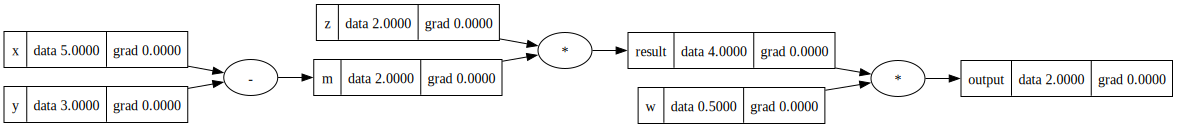

In [5]:
visualize_graph(output)

# Backward pass

In [6]:
def test():
  
  h = 0.001
  x = Node(5.0, name='x')
  y = Node(3.0, name='y')
  z = Node(2.0, name='z')
  w = Node(0.5, name='w')
  m = x - y; m.name = 'm'
  result = m * z; result.name = 'result'
  output = result * w; output.name = 'output'
  output1 = output.data

  x = Node(5.0, name='x')
  y = Node(3.0 + h, name='y')
  z = Node(2.0, name='z')
  w = Node(0.5, name='w')
  m = x - y; m.name = 'm'
  m.data
  result = m * z; result.name = 'result'
  result.data 
  output = result * w; output.name = 'output'
  output2 = output.data

  print((output2 - output1)/h)

test()

-0.9999999999998899


In [7]:
output.gradient = 1.0
w.gradient = 4.0
result.gradient = 0.5
z.gradient = 1.0
m.gradient = 1.0
x.gradient = 1.0
y.gradient = -1.0

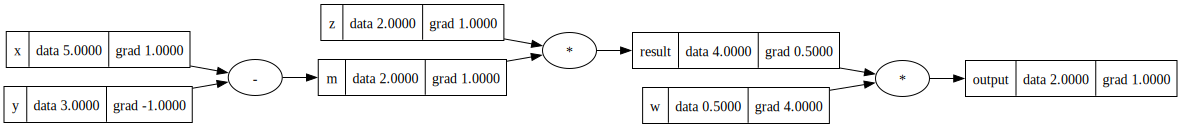

In [8]:
visualize_graph(output)

### simple optimization preview

In [ ]:
x.data += 0.01 * x.gradient
y.data += 0.01 * y.gradient
z.data += 0.01 * z.gradient
w.data += 0.01 * w.gradient

m = x - y
result = m * z
output = result * w

print(output.data)  # 2.192

2.1925079999999997


## MLP

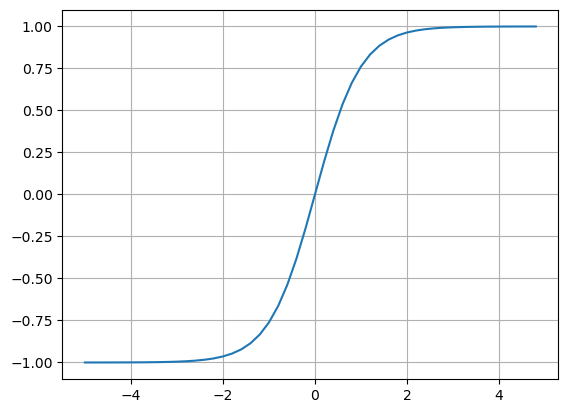

In [71]:
# tanh
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

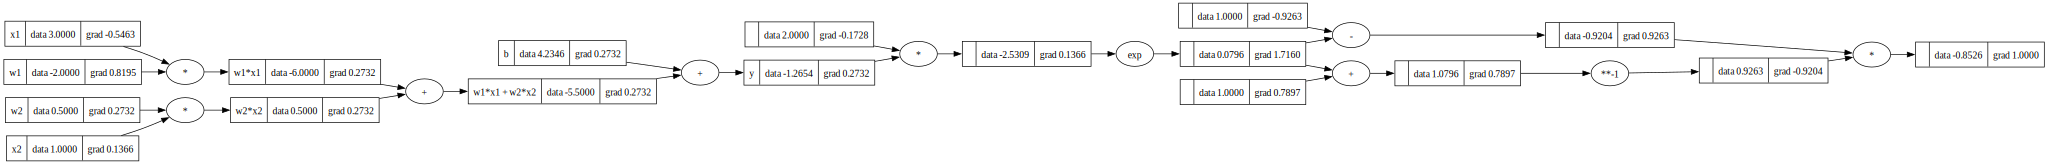

In [96]:
# inputs / reset
x1 = Node(3.0, name='x1')
x2 = Node(1.0, name='x2')
# weights 
w1 = Node(-2.0, name='w1')
w2 = Node(0.5, name='w2')
# bias of the neuron
b = Node(4.2345678901234567, name='b')
# w1x1 + w2x2 + b
w1x1 = w1 * x1; w1x1.name = 'w1*x1'
w2x2 = w2 * x2; w2x2.name = 'w2*x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.name = 'w1*x1 + w2*x2'
y = w1x1w2x2 + b; y.name = 'y'
# act = y.tanh(); act.name = 'act'
#--- tach ham tanh
e = (2*y).exp()
act = (e - 1) / (e + 1)
#---
act.backward()
visualize_graph(act)

### manual backprop

In [25]:
act.gradient = 1.0
y.gradient = 0.3

w1x1w2x2.gradient = 0.3
b.gradient = 0.3

w1x1.gradient = 0.3
w2x2.gradient = 0.3

w2.gradient = 0.3
x2.gradient = 0.15

x1.gradient = -0.6
w1.gradient = 0.9


### backprop

In [57]:
act.gradient = 1.0
act._backward_fn()

In [59]:
y._backward_fn()

In [61]:
b._backward_fn()

In [65]:
w1x1w2x2._backward_fn()

In [67]:
w2x2._backward_fn()

In [69]:
w1x1._backward_fn()

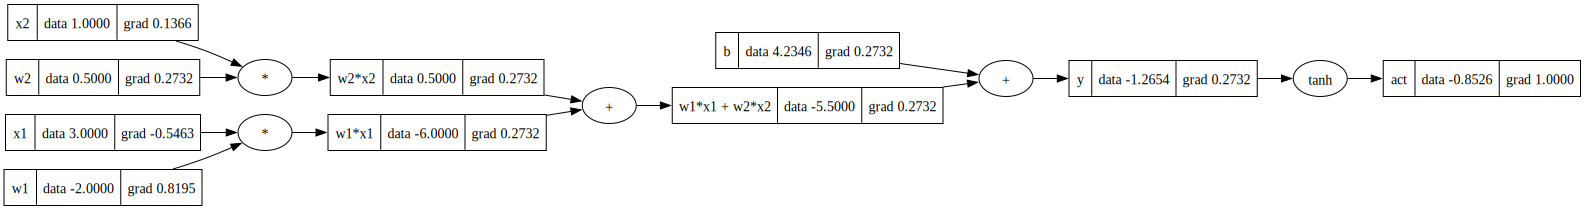

In [70]:
visualize_graph(act)

### build topological tren tung node con

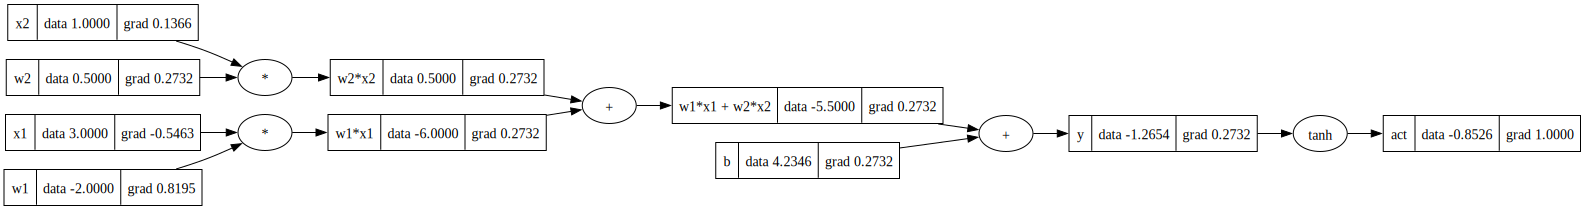

In [73]:
act.gradient = 1.0

topo = []
visited = set()
def build_topo(node):
  if node not in visited:
    visited.add(node)
    for input_node in node._inputs:
      build_topo(input_node)
    topo.append(node)
build_topo(act)

for node in reversed(topo):
  node._backward_fn()
  
visualize_graph(act)

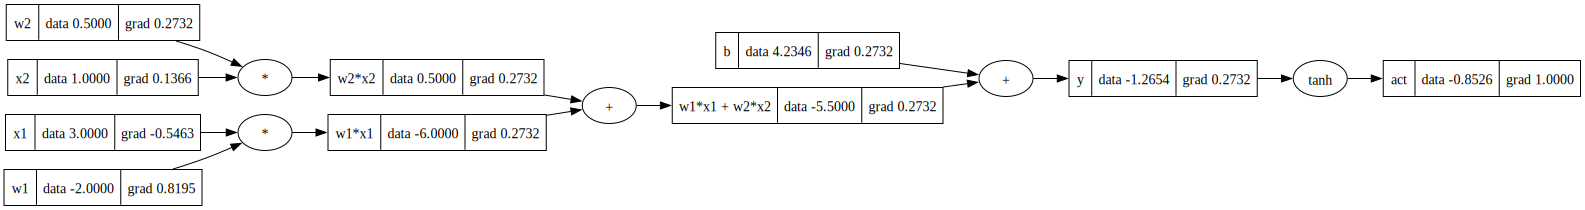

In [76]:
# run real backward
act.backward()
visualize_graph(act)

### Thu vien PyTorch

In [98]:
# example
torch.Tensor([[1,2], [3,4], [5,6]])

tensor([[1., 2.],
        [3., 4.],
        [5., 6.]])

In [97]:
import torch
x1 = torch.Tensor([3.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([1.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-2.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([0.5]).double()                ; w2.requires_grad = True
b = torch.Tensor([4.2345678901234567]).double()  ; b.requires_grad = True
y = w1*x1 + w2*x2 + b
act = torch.tanh(y)

print(act.data.item())
act.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

-0.8525547187167553
---
x2 0.13657522579689715
w2 0.2731504515937943
x1 -0.5463009031875886
w1 0.8194513547813829


In [100]:
torch.Tensor([3.0]).dtype 
# torch.Tensor([3.0]).double().dtype

torch.float32

## Build neural net

In [105]:
class Neuron:

  def __init__(self, num_inputs):
    self.params = [Node(random.uniform(-1,1)) for _ in range(num_inputs)]
    self.bias = Node(random.uniform(-1,1))

  def __call__(self, inputs):
    # params * inputs + bias
    activation = sum((param_i*input_i for param_i, input_i in zip(self.params, inputs)), self.bias)
    output = activation.tanh()
    return output

inputs = [1.0, 2.0, 3.0]
neuron = Neuron(3)
neuron(inputs)

Node(data=0.9936357274461598)

In [108]:
class Layer:
  def __init__(self, num_inputs, num_outputs):
    self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

  def __call__(self, inputs):
    outputs = [neuron(inputs) for neuron in self.neurons]
    return outputs

inputs = [1.0, 2.0, 3.0]
layer = Layer(3, 5)
layer(inputs)

[Node(data=-0.33837393872891564),
 Node(data=-0.9907247134364068),
 Node(data=0.4455504115329716),
 Node(data=0.9995241125900557),
 Node(data=-0.9970284201893322)]